## Import libraries and load data

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import pandas as pd
from torch.utils.data import DataLoader

In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

out = np.load('disc-benchmark-files/training-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('disc-benchmark-files/test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

cuda


## Visualize data

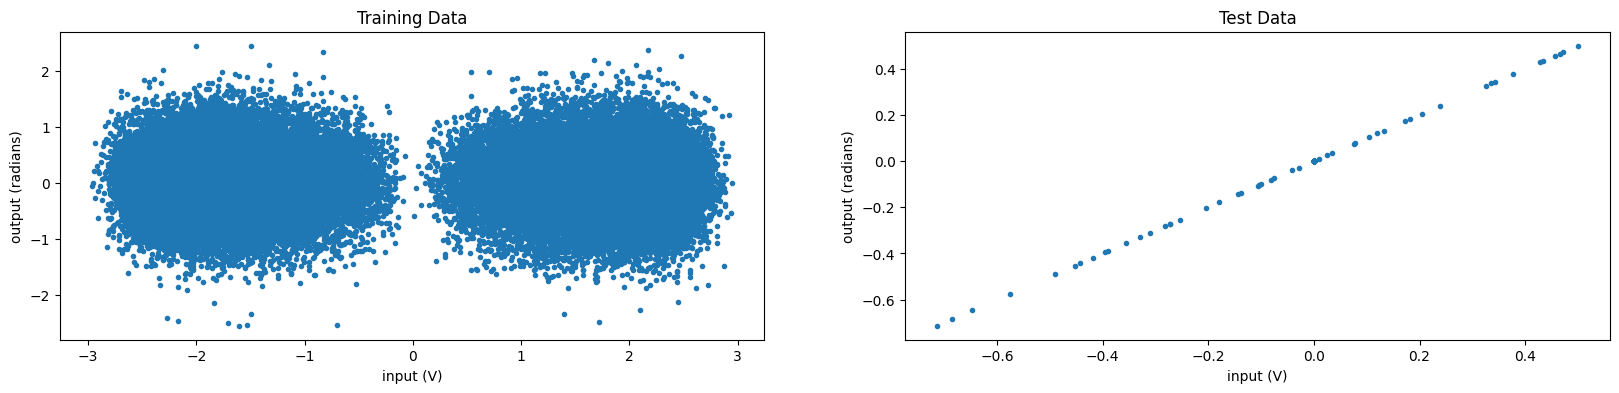

In [13]:
# Plotting the data
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(u_train,th_train,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Training Data')
plt.subplot(1,2,2)
plt.plot(th_test,th_test,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Test Data')
plt.show()

## 1. ANN

In [14]:
def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [15]:
'''three layers'''
class Network(nn.Module): 
    def __init__(self, n_in, n_hidden_nodes): 
        super(Network,self).__init__() 
        self.lay1 = nn.Linear(n_in,n_hidden_nodes)
        self.lay2 = nn.Linear(n_hidden_nodes,64)
        self.lay3 = nn.Linear(64,32)
        self.lay4 = nn.Linear(32,1)
        # self.dropout = nn.Dropout(0.5)
        
    def forward(self,x): 
        x1 = torch.relu(self.lay1(x))

        x2 = torch.relu(self.lay2(x1))

        x3 = torch.relu(self.lay3(x2))
        # x3 = self.dropout(x3)

        y = self.lay4(x3)[:,0] 
        return y 

'''two layers'''
# class Network(nn.Module): 
#     def __init__(self, n_in, n_hidden_nodes): 
#         super(Network,self).__init__() 
#         self.lay1 = nn.Linear(n_in,n_hidden_nodes)
#         self.lay2 = nn.Linear(n_hidden_nodes,64)
#         self.lay3 = nn.Linear(64,1)
#     def forward(self,x): 
#         x1 = torch.relu(self.lay1(x))
#         x2 = torch.relu(self.lay2(x1))
#         y = self.lay3(x2)[:,0] 
#         return y 

'''only one hidden layer'''
# class Network(nn.Module): 
#     def __init__(self, n_in, n_hidden_nodes): 
#         super(Network,self).__init__() 
#         self.lay1 = nn.Linear(n_in,n_hidden_nodes)
#         self.lay2 = nn.Linear(n_hidden_nodes,1)
#     def forward(self,x): 
#         x1 = torch.relu(self.lay1(x)) 
#         y = self.lay2(x1)[:,0] 
#         return y 

'only one hidden layer'

In [16]:
def RMS(y_pred, y_truth):
    y_pred = y_pred.detach().cpu()
    y_truth = y_truth.detach().cpu()
    RMS = (torch.mean((y_pred-y_truth)**2))**0.5
    NRMS = RMS/torch.std(y_truth)
    return RMS, NRMS

In [17]:
class Trainer:
    def __init__(self, model, data):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.data = data

        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-4)
        self.critereon = nn.MSELoss()

        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"


    def train_epoch(self, inputs, truths):
            # Put the model in training mode
            self.model.train()

            # Store each step's accuracy and loss for this epoch
            epoch_metrics = {
                "loss": [],
                "RMS": [],
                "NRMS": []
            }

            # Zero the gradients from the previous step
            self.optimizer.zero_grad()

            # Move the inputs and truths to the target device
            inputs = inputs.to(device=self.device)
            truths = truths.to(device=self.device)

            # Run model on the inputs
            output = self.model(inputs)
            
            # Perform backpropagation
            loss = self.critereon(output, truths)
            loss.backward()
            self.optimizer.step()

            # Store the metrics of this step
            step_metrics = {
                'loss': loss.item(),
                'RMS': RMS(output, truths)[0],
                'NRMS': RMS(output, truths)[1]
            }

            # Add to epoch's metrics
            for k,v in step_metrics.items():
                epoch_metrics[k].append(v)

            # Return metrics
            return epoch_metrics
    
    def val_epoch(self, inputs, truths):
        epoch_metrics = {
                "loss": [],
                "RMS": [],
                "NRMS": []
            }

        # Put the model in evaluation mode
        self.model.eval()
        with torch.no_grad():
            # Move the inputs and truths to the target device
            inputs = inputs.to(device=self.device, dtype=torch.float32)
            truths = truths.to(device=self.device, dtype=torch.float32)

            # Run model on the inputs
            output = self.model(inputs)
            loss = self.critereon(output, truths)

            # Store the metrics of this step
            step_metrics = {
                'loss': loss.item(),
                'RMS': RMS(output, truths)[0],
                'NRMS': RMS(output, truths)[1]
            }

            # Add to epoch's metrics
            for k,v in step_metrics.items():
                epoch_metrics[k].append(v)

        # Return metrics
        return epoch_metrics
    
    # def fit(self, epochs: int):
    #     # Store metrics of the training process (plot this to gain insight)
    #     df_train = pd.DataFrame()
    #     df_val = pd.DataFrame()

    #     # Train the model for the provided amount of epochs
    #     for epoch in range(1, epochs+1):
    #         # print(f'Epoch {epoch}')
            
    #         metrics_train = self.train_epoch(self.data["Xtrain"],self.data["Ytrain"])
    #         df_train = pd.concat([df_train,pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train})], ignore_index=True)
            
    #         metrics_val = self.val_epoch(self.data["Xval"],self.data["Yval"])
    #         df_val = pd.concat([df_val,pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_val["loss"]))], **metrics_val})], ignore_index=True)

    #         loss_train = metrics_train["loss"]
    #         loss_val = metrics_val["loss"]
    #         RMS_val = metrics_val["RMS"]
    #         NRMS_val = metrics_val["NRMS"]

    #         if (epoch + 1) % 2000 == 0:
    #             print('epoch =', epoch+1, 'Train_loss =',loss_train, 'Val_loss =', loss_val, 'Val_RMS =', RMS_val, 'Val_NRMS =', NRMS_val)
        
    #     # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
    #     return df_train, df_val
    

    '''mini batch'''
    def fit(self, epochs: int, batch_size: int):
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        num_samples = len(self.data["Xtrain"])
        num_batches = num_samples // batch_size

        for epoch in range(1, epochs+1):
            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = (batch + 1) * batch_size

                batch_X = self.data["Xtrain"][start_idx:end_idx]
                batch_Y = self.data["Ytrain"][start_idx:end_idx]

                metrics_train = self.train_epoch(batch_X, batch_Y)
                df_train = pd.concat([df_train, pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train})], ignore_index=True)

                metrics_val = self.val_epoch(self.data["Xval"], self.data["Yval"])
                df_val = pd.concat([df_val, pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_val["loss"]))], **metrics_val})], ignore_index=True)

                loss_train = metrics_train["loss"]
                loss_val = metrics_val["loss"]
                RMS_val = metrics_val["RMS"]
                NRMS_val = metrics_val["NRMS"]

            if (epoch + 1) % 2000 == 0:
                print('epoch =', epoch+1, 'Train_loss =', loss_train, 'Val_loss =', loss_val, 'Val_RMS =', RMS_val, 'Val_NRMS =', NRMS_val)

        return df_train, df_val


        

In [18]:
na, nb = 6, 11
Xdata, Ydata = create_IO_data(u_train,th_train,na,nb) # For training data
Xtest, Ytest = create_IO_data(u_test,th_test,na,nb)    # For simulation data

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata,Ydata)
device="cuda" if torch.cuda.is_available() else "cpu"

Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [Xtrain, Xval, Ytrain, Yval]]
Xtest_simulation, Ytest_simulation = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [Xtest[0:50-max(na,nb)], Ytest[0:50-max(na,nb)]]]
u_test_sim = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [u_test[0:50]]][0].squeeze()#.unsqueeze(0)#.unsqueeze(1)#.unsqueeze(0)
# Xtest_simulation, Ytest_simulation = Xtest[0:50-max(na,nb)], Ytest[0:50-max(na,nb)]
th_test_sim = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [th_test[0:50]]][0].squeeze()

In [19]:
data = {
    "Xtrain": Xtrain,
    "Xval": Xval,
    "Ytrain": Ytrain,
    "Yval": Yval
}

In [20]:
from pathlib import Path

# create folder
folder_name = '6_11_test_simulation'
p_model = (Path()/'Train_ANN'/folder_name)
p_model.mkdir(parents=True, exist_ok=True)

# free memory
torch.cuda.empty_cache()

# Train the passthrough network
print("Training...")
model = Network(na+nb,n_hidden_nodes=64)

epochs = 20000
trainer = Trainer(model, data)
train_resluts, validation_results = trainer.fit(epochs=epochs,batch_size=29500)

# save model in the folder
model_name = f"model.pth"
torch.save(model.state_dict(),(p_model/model_name))

# save dataframe file
train_resluts.to_csv((p_model/f"train_loss.csv"))
validation_results.to_csv((p_model/f"validation_loss.csv"))

Training...
epoch = 2000 Train_loss = [0.00035801154444925487] Val_loss = [0.00036377020296640694] Val_RMS = [tensor(0.0191)] Val_NRMS = [tensor(0.0391)]
epoch = 4000 Train_loss = [6.514330016216263e-05] Val_loss = [7.070587162161246e-05] Val_RMS = [tensor(0.0084)] Val_NRMS = [tensor(0.0172)]
epoch = 6000 Train_loss = [2.319730629096739e-05] Val_loss = [2.697145100682974e-05] Val_RMS = [tensor(0.0052)] Val_NRMS = [tensor(0.0106)]
epoch = 8000 Train_loss = [1.410084678354906e-05] Val_loss = [1.618910209799651e-05] Val_RMS = [tensor(0.0040)] Val_NRMS = [tensor(0.0082)]
epoch = 10000 Train_loss = [1.1928288586204872e-05] Val_loss = [1.3463771210808773e-05] Val_RMS = [tensor(0.0037)] Val_NRMS = [tensor(0.0075)]
epoch = 12000 Train_loss = [1.0034028491645586e-05] Val_loss = [1.144273755926406e-05] Val_RMS = [tensor(0.0034)] Val_NRMS = [tensor(0.0069)]
epoch = 14000 Train_loss = [8.866645657690242e-06] Val_loss = [9.992018931370694e-06] Val_RMS = [tensor(0.0032)] Val_NRMS = [tensor(0.0065)]


## Simulation

In [21]:
def get_NARX_data(ulist, f, na, nb):
    
    # iteratively uses the given f to find the new output.
    upast = u_test_sim[max(na,nb)-nb:max(na,nb)]
    ypast = th_test_sim[max(na,nb)-na:max(na,nb)]

    ylist = []
    for unow in ulist[nb:]:
        with torch.no_grad():
            ynow = f(upast,ypast).unsqueeze(0)

            #update past arrays
            upast = torch.cat((upast,unow.unsqueeze(0)))[1:]
            ypast = torch.cat((ypast,ynow[0]))[1:]
            
            #save result
            ylist.append(ynow)
            
    return ylist

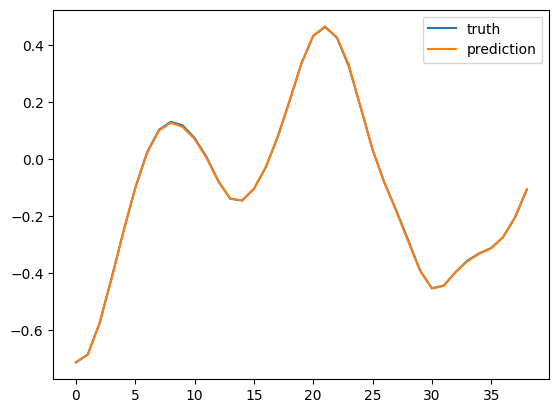

RMS = 0.0021959283729628106
NRMS = 0.007424833755618749


In [22]:
fmodel = lambda u,y: model.forward(torch.cat([u,y]).squeeze().unsqueeze(0))
Ytest_sim_pred = get_NARX_data(u_test_sim, fmodel, na, nb)
# print(Ytest_sim_pred)
output = np.concatenate([tensor.cpu().numpy() for tensor in Ytest_sim_pred])
plt.plot(th_test[max(na,nb):50],label="truth") 
plt.plot(output,label="prediction")
# plt.plot(th_test[0:50]-output)
plt.legend()
plt.show() 
print('RMS =',np.mean((th_test[max(na,nb):50].squeeze()-output.squeeze())**2)**0.5)
print('NRMS =',np.mean((th_test[max(na,nb):50].squeeze()-output.squeeze())**2)**0.5/np.std(th_test[max(na,nb):50].squeeze()))


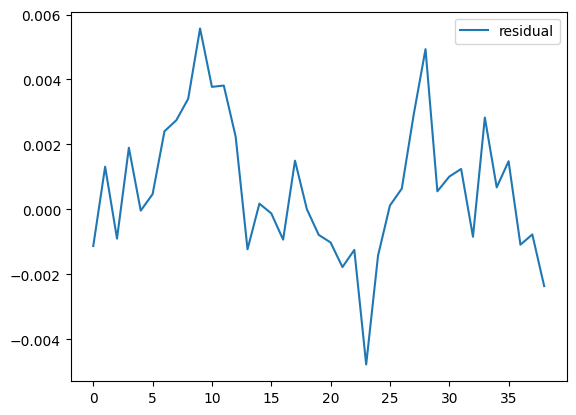

In [23]:
plt.plot(th_test[max(na,nb):50].squeeze()-output.squeeze(),label="residual")
plt.legend()
plt.show() 